In [34]:
import json
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = "["
with open("../aminer_papers_0.txt") as myfile:
    counter = 0 
    for line in myfile:
        counter += 1
        data += line + ","
        if counter > 30000:
            break

data = data[:-1] + "]"

In [3]:
json_data = json.loads(data)

In [21]:
len(json_data)
json_data[0]

{'authors': [{'name': 'G. Adam'}, {'name': 'K. Schreiber'}],
 'doi': '10.1002/ange.19650770204',
 'id': '53e99784b7602d9701f3e130',
 'issue': '2',
 'lang': 'en',
 'page_end': '95',
 'page_start': '94',
 'references': ['53e9a6e6b7602d970301a47d',
  '53e9b4dfb7602d97040028e8',
  '56d83d06dabfae2eee6b7929'],
 'title': '1.4-N→N′-Acylwanderung bei einem Diaminosteroid',
 'url': ['http://dx.doi.org/10.1002/ange.19650770204'],
 'venue': 'Angewandte Chemie',
 'volume': '77',
 'year': 1965}

In [5]:
paper_to_authors = dict()
paper_to_journal = dict()

for paper_obj in json_data:
    if 'id' in paper_obj and 'authors' in paper_obj and 'venue' in paper_obj:
        paper = paper_obj['id']
        authors = paper_obj['authors']
        journal = paper_obj['venue']
        
        paper_to_authors[paper] = [author['name'] for author in authors]
        paper_to_journal[paper] = journal

In [233]:
len(paper_to_authors)

23965

In [22]:
author_to_author_and_papers = dict()

for paper_obj in json_data:
    if 'references' in paper_obj and 'authors' in paper_obj and 'venue' in paper_obj:
        paper_refs = paper_obj['references']
        author_and_papers = dict()
        for paper_ref in paper_refs:
            if paper_ref in paper_to_authors:
                authors = paper_to_authors[paper_ref]
                for author in authors:
                    if author not in author_and_papers:
                        author_and_papers[author] = [paper_ref]
                    else:
                        author_and_papers[author].append(paper_ref)
        for author in paper_obj['authors']:
            author_to_author_and_papers[author['name']] = author_and_papers

In [23]:
cleaned_author_to_etc = dict()

for obj in author_to_author_and_papers.keys():
    if author_to_author_and_papers[obj]:
        cleaned_author_to_etc[obj] = author_to_author_and_papers[obj]

In [24]:
# author_to_author_and_papers = cleaned_author_to_etc

In [10]:
len(author_to_author_and_papers)

6850

In [60]:
#returns id of author chosen uniformly randomly
def randStartPoint():
    idx = np.random.randint(len(author_to_score))
    return list(author_to_score.keys())[idx]   #perhaps sorting issues here? check later

def getScore(cur_author, proposed_author):
    papers = author_to_author_and_papers[cur_author][proposed_author]
    score = 0
    for paper in papers:
#         print(paper)
#         print(paper_to_authors[paper])
        paper_authors = paper_to_authors[paper]
        avg_author_score = np.mean([author_to_score[auth] for auth in paper_authors if auth in author_to_score])
        score += avg_author_score * paper_to_if[paper]
    
    return score

In [95]:
#to do: sum up multiple papers btwn a and b

#update author_to_score every iteration
def graphtraversal(num_trials, num_walks_per_trial):
    output = np.zeros((num_trials, numAuthors))   #matrix of all results. sorted by author id's.
    
    for i in range(num_trials):
#         authors_explored = []
#         print()
        print("trial number ", str(i))
    
        #select uniform start point
        cur_author = randStartPoint()
#         authors_explored.append(cur_author)
        
#         print("start at ", cur_author)
        
        for num_walk in range(num_walks_per_trial):
            #calculate next author to go to (propose next state) according to dist. 1/d for current node
            if len(author_to_author_and_papers[cur_author]) == 0: #current author is a dead end
                cur_author = randStartPoint()
#                 authors_explored.append(cur_author)
#                 print("dead end at ", cur_author)
            else:
                tries = 10
                for t in range(tries):
                    idx = np.random.randint(len(author_to_author_and_papers[cur_author]))
                    proposed_author = list(author_to_author_and_papers[cur_author].keys())[idx]
                    if proposed_author in author_to_score:
                        break
                        
                if proposed_author not in author_to_score:
                    cur_author = randStartPoint()
#                     authors_explored.append(cur_author)
                    continue

#                 print("proposed author: ", proposed_author)

                #accept or not? according to metropolis hastings 
                pi_y = author_to_score[proposed_author]  #pi(x) = score(x)
                pi_x = author_to_score[cur_author]
                if len(author_to_author_and_papers[proposed_author]) == 0:  #if proposed author is a sink
                    f_y = 1
                else:
                    f_y = 1 / len(author_to_author_and_papers[proposed_author]) #f(x) = 1/d where d is degree of node x (number of outgoing edges)
                if len(author_to_author_and_papers[cur_author]) == 0:
                    f_x = 1
                else:
                    f_x = 1 / len(author_to_author_and_papers[cur_author]) #maybe float errors here
                
#                 print("pi_y: ", str(pi_y))
#                 print("pi_x: ", str(pi_x))
#                 print("f_y: ", str(f_y))
#                 print("f_x: ", str(f_x))
#                 print("calculated: ", (pi_y * f_y) / (pi_x * f_x))
                p_accept = min(1, (pi_y * f_y) / (pi_x * f_x))
                if p_accept < 1:
                    print("yay")

#                 print("p accept", str(p_accept))

                if proposed_author in author_to_score and np.random.random() < p_accept and proposed_author != cur_author:
                    #if accept, update proposed_author's score.  Then move to proposed_author
                    author_to_score[proposed_author] += getScore(cur_author, proposed_author)
                    cur_author = proposed_author
#                     authors_explored.append(cur_author)
                    
#                     print("printing all scores before norm...")
#                     for author, score in zip(author_to_score.keys(), author_to_score.values()):
#                         print("author: ", author)
#                         print("score: ", score)

                    #renormalize everyone author's score
#                     norm_score = sum(author_to_score.values())
#                     norm_score = max(author_to_score.values())

#                     print("printing all scores...")
#                     for author in author_to_score:
#                         author_to_score[author] = author_to_score[author] / norm_score
#                         print("author: ", author)
#                         print("score: ", author_to_score[author])

                else:  #if not accept, randomly start again
                    cur_author = randStartPoint()
#                     authors_explored.append(cur_author)
#                     print("start again at ", cur_author)
        
        #add trial results to output matrix
        sum_score = sum(author_to_score.values())
        output[i] = np.array(list(author_to_score.values()))  #hopefully sorted? check here too
                                                        #don't think this numpy notation works. tweak later lol
#         print("# authors explored: ", len(authors_explored))
#         print(set(authors_explored), len(set(authors_explored)))
     
    avg_output = np.mean(output, axis=0) #columnwise avg for each author
    return output, avg_output

In [96]:
numAuthors = len(author_to_author_and_papers)
startScore = 1
author_to_score = collections.OrderedDict([(author, startScore) for author in author_to_author_and_papers.keys()])

value = 5
paper_to_if = {key:value for key in paper_to_journal.keys()}
output, avg_output = graphtraversal(1, 1000)

trial number  0
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
yay


(array([6.833e+03, 8.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.   ,  7.125, 13.25 , 19.375, 25.5  , 31.625, 37.75 , 43.875,
        50.   , 56.125, 62.25 ]),
 <a list of 10 Patch objects>)

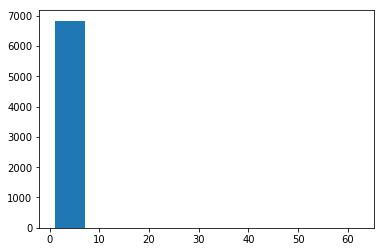

In [103]:
plt.hist(author_to_score.values())

In [106]:
for author in sorted(author_to_score, key=author_to_score.get, reverse=True):
    print (author, author_to_score[author])

Carl J Vaughan 62.25
Günter Steinorth 36.55555555555556
Pam Marek 34.685769569887796
Todd Riniolo 32.91021788129226
Edward Smith 28.44766409398265
Tracie Stewart 24.4297520661157
Norman Delanty 23.5
U Rüdiger 16.4312414266118
Walter Olk 14.333333333333332
John Sappington 12.25
Catherine McBride-Chang 11.0
Richard Leit 9.88888888888889
Dennis P. Curran 9.571428571428571
J Llandro 9.163580246913579
John Best 8.5
Myra Cummings-Hill 7.666666666666666
M Laufenberg 7.388888888888888
Richard A. Mladick 6.0
Heinrich Bartelheimer 6.0
Kelly Selchow Detweiler 6.0
Mark Sciutto 6.0
A. F. D. Cole 6.0
Lotfi A. Zadeh 6.0
Ilhyong Ryu 6.0
D A. Whitelaw 6.0
Ed Brinksma 6.0
Lothar Knothe 6.0
A. Scedrov 6.0
S. V. N. Vishwanathan 6.0
G. Adam 1
K. Schreiber 1
Peijuan Wang 1
Jiahua Zhang 1
Donghui Xie 1
Yanyan Xu 1
Yun Xu 1
D J Lum 1
V Upadhyay 1
A Smith 1
J McFarlane 1
Asami Nakai 1
Akio Ohtani 1
Takeru Ohki 1
Toshiko Osada 1
Masaharu Iwamoto 1
Hiroyuki Hamada 1
Nobuo Takeda 1
Pelin Arda-Pirincci 1
Sehnaz Bo

XiaoFeng Lei 1
Koji Ohnishi 1
Hiroshi Suzuki 1
Tatsuhiko Kodama 1
Hiroshi Mizuta 1
Motohiro Takeya 1
Kyoung-Suk Kim 1
Yong-Kul Lee 1
Ole Risgaard 1
Michael Sugrue 1
Scott D?Amours 1
Grant Christey 1
Katherine Smith 1
Erica Caldwell 1
Christian Larivière 1
Stuart McKelvie 1
Christine Daprat 1
Patricia Monfette 1
Diana Cooper 1
S. Heath Wanamaker 1
Kevin J. Schmitt 1
Doug A. Lupher 1
Nathan C. Stockman 1
David S. Brooks 1
Ryan A. Parks 1
Thatcher D. Reist 1
Matthew R. Kyle 1
Pedro L. Muiño 1
C. Holdstock 1
J. Ludvigsson 1
F. A. Karlsson 1
V. B. Khudyakov 1
X. Chen 1
M.C. Benjamin 1
R.J. Hillard 1
J.O. Borland 1
Roger Harrison 1
Richard Edwards 1
Jonathan Brown 1
Douglas Gale 1
Robert W. Rosenthal 1
Cz. Kapusta 1
M. Rosenberg 1
R.G. Graham 1
P.C. Riedi 1
T.H. Jacobs 1
K.H.J. Buschow 1
Jeffrey K Aronson 1
Sugjoon Yoon 1
Jaechun No 1
Jon Ahn 1
Carmen Rojo 1
Elizabeth Ortega-Mayagoitia 1
Miguel Alvarez-Cobelas 1
Lajos Horváth 1
Marie Hušková 1
Piotr Kokoszka 1
J. Weidenfeld 1
I. Chowers 1
N.

N.P. Kolmakova 1
I.B. Krynetskii 1
Jiangtao Feng 1
Wei Yan 1
Linzi Zhang 1
P. T. While 1
L. K. Forbes 1
S. Crozier 1
f kosters 1
r h kase 1
kevin fleming 1
detlef wolf 1
Yasushi Matsui 1
C. A. Hooker 1
Boaz Barak 1
A Shenhar 1
Symeon Papadopoulos 1
Athena Vakali 1
Ioannis Kompatsiaris 1
Douglas O.A. Osula 1
O. Adebisi 1
Walter S. Selig 1
Tamás Nepusz 1
Tamás Vicsek 1
J. MAASand 1
G. M. BUENING 1
W. PORATH 1
David Morris 1
Maha Al Dabbagh 1
M. J. M. Pelgrom 1
L. J. M. Esser 1
U.A. Khashaba 1
J. Prichard 1
S. Allwright 1
M. NcSweeney 1
D. Macleod 1
M. O’Regan 1
R. A. Lyons 1
C. K. Power 1
S. Sreenan 1
C. M. Burke 1
L. Daly 1
M. Lonergan 1
I. Graham 1
W. Zhang 1
J. M. Bard 1
E. E. McCrum 1
D. McMaster 1
J. C. Fruchart 1
F. Cambien 1
A. E. Evans 1
N. Ryan 1
R. Clarke 1
R. Robinson 1
R. Refsum 1
P. Ueland 1
N. Lonergan 1
A. O’Donnell 1
E. McGivern 1
Y. Ben-Shlomo 1
F. Finnan 1
G. Davey Smith 1
M. McArdle 1
C. C. Kelleher 1
J. Ward 1
S. E. Broodle 1
G. M. Bleakney 1
B. M. Cullen 1
A. T. Gavi

Jian Zhao 1
Atorn Nuntiyagul 1
Kanlaya Naruedomkul 1
Nick Cercone 1
Damras Wongsawang 1
Federico D. Ariel 1
Pablo A. Manavella 1
Carlos A. Dezar 1
Raquel L. Chan 1
Patrick J. Rabier 1
masafumi hirahara 1
kanako seki 1
yoshifumi saito 1
t mukai 1
J. I. Colonell 1
K. D. Gibson 1
S. J. Sibener 1
Wendy Bensussen-Walls 1
Elizabeth M. Saewyc 1
G Steffenino 1
B Meier 1
L Finci 1
L von Segesser 1
V Velebit 1
A. Chatterjee 1
S. K. Gupta 1
Min-Ja LEE 1
Hye-Sook LEE 1
Sun-Dong PARK 1
Hyung-In MOON 1
Won-Hwan PARK 1
Suk-Ling Li 1
Kai-Chi Leung 1
L. M. Cheng 1
Chi-Kwong Chan 1
Iris F.F. Benzie 1
Angelika Bierhaus 1
Jutta Wolf 1
Martin Andrassy 1
Nicolas Rohleder 1
Per M. Humpert 1
Dimitri Petrov 1
Roman Ferstl 1
Maximilian von Eynatten 1
Thoralf Wendt 1
Gottfried Rudofsky 1
Martina Joswig 1
Michael Morcos 1
Markus Schwaninger 1
Bruce McEwen 1
Clemens Kirschbaum 1
Peter P. Nawroth 1
Jens Friis Lund 1
J. Peter Slotte 1
Stig Ekman 1
David Hamburg 1
Beatrix Hamburg 1
V. Hömberg 1
U. Bickmann 1
K. Mülle

Sara Marinari 1
Alessandro D’Annibale 1
Stefano Grego 1
Juan A. Ocampo 1
Inmaculada García-Romera 1
juan v esplugues 1
Barrachina M D 1
Beltrán B 1
Calatayud S 1
Whittle B J 1
Moncada S 1
M. E. Steinberg 1
Paul H. Starr 1
David L. Rayle 1
Robert Cleland 1
Komei Nakayama 1
Hideo Orihata 1
Keizo Yamaguchi 1
Urs Knobel 1
Goli Modarres 1
Markus Schneemann 1
Yasushi Fujii 1
Masanori Kuriyama 1
Yukuo Konishi 1
Masakazu Saito 1
Masakatsu Sudo 1
W WANG 1
F ZHOU 1
L ZHAO 1
J ZHANG 1
J ZHU 1
Isabelle Godard 1
Jérôme Estaquier 1
Lionel Zenner 1
Marc Bossus 1
Claude Auriault 1
Françoise Darcy 1
Helène Gras-Masse 1
André Capron 1
M. N. KOLTSA 1
G. N. MIRONOV 1
S. T. MALINOVSKII 1
P. F. VLAD 1
DOMINIC A. INFANTE 1
ANDREW S. RANGER 1
FELECIA F. JORDAN 1
P YANG 1
Julie A. Hood 1
Michael Schoenberg 1
T. A. Thorson 1
R. D. Durst 1
R. J. Fonck 1
L. P. Wainwright 1
R. Cristiano 1
L. Frunzio 1
C.S. Pagano 1
V.G. Palmieri 1
G.P. Pepe 1
H. Nakagawa 1
M.P. Lisitskii 1
Yoon Ju Lee 1
Sung Cheol Chang 1
Young Il

Larsson KH 1
Abarenkov K 1
Nilsson RH 1
Alexander IJ 1
Kristiansson E 1
Ryberg M 1
Philip J. Cook 1
Mark H. Moore 1
Anthony A. Braga 1
H. BONDI 1
D. A. Dawson 1
Nathan Chow 1
Justin Khoury 1
E. N. Glass 1
Lars-Owe Martinez Tomalino 1
Wolfgang Peukert 1
A. Stephen K. Hashmi 1
Graham J. Hutchings 1
Uwe Beginn 1
Anthony J. O'Lenick 1
Hoong-Kun Fun 1
Jia Hao Goh 1
Arnab Kar 1
Shyamaprosad Goswami 1
Sanjeev Misra 1
Arun Chaturvedi 1
N. C. Misra 1
Sanjay Marwah 1
Rajesh Godara 1
Ashish Goel 1
Nisha Marwah 1
Rajender Karwasra 1
P. Stubbe Teglbjaerg 1
M. Vetner 1
Susan Malter 1
J. R. Whittier 1
T. Petit 1
Robert C. Drews 1
Roberto P. Mesquita 1
R. Rabin 1
P. Chaturvedi 1
Rebecca M. Thomas 1
Leslie H. Sobin 1
Martin S. Karpeh 1
Murray F. Brennan 1
S. G. Xu 1
R. B. Zotz 1
G. von Recklinghausen 1
P. Meusers 1
H. Goebell 1
M. A. K. Khandekar 1
A. M. Lesseis 1
M. A. Eastwood 1
K. R. Palmer 1
C. Rizzi 1
C. Avellini 1
C. A. Scott 1
G. Floretti 1
L. Desinan 1
C. A. Beltrami 1
H. Igarashi 1
S. Takahash

F. Delduc 1
L. Frappat 1
E. Ragoucy 1
P. Sorba 1
Ricardo Hausmann 1
Lant Pritchett 1
Dani Rodrik 1
V. E. Govorov 1
D. P. Zhelobenko 1
H. Leutwyler 1
S. Mallik 1
Harald Sch�fer 1
Claus Brendel 1
Helmut Rabeneck 1
Eduard Schibilla 1
Anson P. Hobbs 1
Walter Lawrence , Jr 1
Hushang M. Payan 1
Enid F. Gilbert 1
Reza Hafez 1
L. Kowalzick 1
E. O. HALLIWELL 1
JOHN T. INGRAM 1
George B. Jerzy Glass 1
L. Samaranayake 1
C. ROBERT CHARLES 1
BERNETT L. JOHNSON 1
STEPHEN R. DAMM 1
Andrew P. Truhan 1
Lauren M. Pachman 1
Nancy B. Esterly 1
E. Pezzarossa 1
A. Alinovi 1
C. Ferrari 1
P. Collins 1
J. A. Cotterill 1
Othon B. Kotoulas 1
Stefanos A. Kalamidas 1
Dimitrios J. Kondomerkos 1
Marios Hadjivassiliou 1
David S. Sanders 1
Nicola Woodroofe 1
Claire Williamson 1
Richard A. Grünewald 1
Povl Krogsgaard-Larsen 1
Erik Falch 1
Michael T. Cahill 1
Halton Arp 1
William Blumen 1
Martin Hendry 1
Graham Woan 1
Anne-Lise Diet 1
Kermit E. Krantz 1
John P. Atkinson 1
Nadia Danilova 1
Chris T. Amemiya 1
Fernando Ped

Joachim Georgii 1
Rudiger Westermann 1
Elisa Baniassad 1
Richard P. Gabriel 1
Yoav Shoham 1
Moshe Tennenholtz 1
Emilie Balland 1
Claude Kirchner 1
Pierre-etienne Moreau 1
Martin Giese 1
Andrew Ireland 1
Laura Kovács 1
Omkant Pandey 1
Julien Cathalo 1
Jean-jacques Quisquater 1
Rolf Kruse 1
Paul Grimm 1
P.J. Bickel 1
E.L. Lehmann 1
Raul Barbosa 1
Johan Karlsson 1
Henrique Madeira 1
Marco Vieira 1
Astri M V Luoma 1
Simon G Clarke 1
Catherine Gamble 1
Ryan Porter 1
Christine D. Hannaway 1
Tracy L. Hull 1
Mark J. Cheetham 1
Andrew J. Malouf 1
Michael A. Kamm 1
Victoria Wahl-Jensen 1
Heinz Feldmann 1
Anthony Sanchez 1
Sherif R. Zaki 1
Pierre Rollin 1
C.J. Peters 1
JohnW. Gerrard 1
Radko Mesiar 1
Andrea Mesiarová 1
Branimir Seselja 1
Andreja Tepavcevic 1
John T. Baldwin 1
Michael C. Laskowski 1
Saharon Shelah 1
Hannu Toivonen 1
George Bebis 1
Purdy Ho 1
Bernd Heisele 1
Mutaz B. Habal 1
S. Antusch 1
S. F. King 1
M. Malinsky 1
L. Velasco-Sevilla 1
I. Zavala 1
Robert D. Arnott 1
Jason Hsu 1
Phil

Q. T. Tran 1
Tony Battaglene 1
Robert Curtotti 1
Tim Bull 1
Bruno Lüthi 1
Stanley David Gedzelman 1
Javier Hernández-Andrés 1
R. Feldtkeller 1
Paul H Wirsching 1
Färkkilä Markus 1
Kallela Mikko 1
M. H. Kanzler 1
K. M. Stein 1
K. Grünberg 1
Michael W. Church 1
Fran Eldis 1
Ken Takizawa 1
Donald R. Mattison 1
S. Asokan 1
Gösta Rooth 1
Douglas Kondziolka 1
Riette du Toit 1
J W. Schneider 1
I. M. L. Marconi 1
M. C. Rivitti-Machado 1
M. N. Sotto 1
M. M. S. Nico 1
Fred A. Mettler 1
J. Preston Maxwell 1
C. H. Hu 1
H. M. Turnbull 1
H. Bernhardt 1
K. Zimmermann 1
M. Knoke 1
Goran Hyden 1
Thomas Craemer 1
Robert E. Goodin 1
Makoto Ito 1
N. Wülker 1
Orthopadische Klinik 1
Harold Thimbleby 1
Olivier Danvy 1
Kenichi Asai 1
Oleg Kiselyov 1
Chung-Chieh Shan 1
Pasi Tyrväskylä 1
R. G. Lawrence 1
K. L. Craven 1
G. D. Nichols 1
David E. Dobbs 1
S. B. Mulay 1
Ulrich Schurath 1
Ákos Jakobovits 1
Antal Jakobovits 1
J. W. Jenne 1
G. Divkovic 1
R. Rastert 1
J. Debus 1
P. E. Huber 1
Richard K. Babayan 1
A. O. 

H. Schaefer 1
U. Blume-Peytavi 1
W. Sterry 1
J. C. King 1
W. H. Brune 1
D. W. Toohey 1
J. M. Rodriguez 1
W. L. Starr 1
J. F. Vedder 1
M. B. Sedel’nikova 1
V. M. Pogrebenkov 1
N. V. Liseenko 1
Nicole J. Martin 1
Barry G. Steinberg 1
John M. Opitz 1
K. Dettner 1
Steven Bender 1
Ute Gappa 1
Janaki Kumar 1
Mario Herger 1
Sebastian Deterding 1
Scott Schnaars 1
Matt Landes 1
Erika Webb 1
Martin Büchi 1
Wolfgang Weck 1
Tristan Cazenave 1
Daniel Sigg 1
Sreekanth H Chalasani 1
Evan H Feinberg 1
Massimo A Hilliard 1
Joseph Weber 1
Günther Wess 1
Alfons Enhsen 1
Werner Kramer 1
Ronald Smith 1
Sylvain Veilleux 1
Gerald Cecil 1
Joss Bland-Hawthorn 1
Erika Check 1
P. D. Simmons 1
Michiel de Cleen 1
Tony Waltham 1
Mary F. Fernández 1
Jérôme Siméon 1
Graciela Wetzler 1
Amy A Felix 1
Jeffrey F Lipton 1
Ph. Rey 1
N. Hamant 1
Ch. Carrere 1
D. Casassus-Builhe 1
F. Klotz 1
Michael Bieber 1
Harri Oinas-Kukkonen 1
V. Balasubramanian 1
Takeo Kanade 1
Takeshi Osoekawa 1
Tateaki Sasaki 1
Maureen Squillace 1
Jen

Douglas B. Brumm 1
Stephen S. H. Hsiao 1
Angel García-Botella 1
Antonio Álvarez Fernández-Balbuena 1
Daniel Vázquez 1
Eusebio Bernabeu 1
Agustín González-Cano 1
A. Bernthsen 1
F. Ekkehardt Hahn 1
Andreas Schwienhorst 1
Andreas Schober 1
Rolf Giinther 1
Peter F. Stadler 1
John F Corbett 1
H. E. Blum 1
Dalila B. Corry 1
Michael L. Tuck 1
Bersano E 1
Zago A J 1
de Mattos A G 1
Vivek Kaul 1
Frank Friedenberg 1
Kenneth D. Rothstein 1
Melinda H. Huffman 1
Nathaniel D. Wycliffe 1
Ryan Shane Grover 1
Paul D. Kim 1
Alfred Simental 1
Graham O. Hughes 1
Ross W. Griffiths 1
Clive W. J. Granger 1
Gawon Yoon 1
P. S. Herman 1
J. E. LEMONS 1
J. M. Torpy 1
Leslie E. Forer 1
William J. Davros 1
Joanne Goldberg 1
Firas Al-Kawas 1
Brian S. Garra 1
Wendelin Hayes 1
Robert K. Zeman 1
Rafael Ponikvar 1
T. Strowitzki 1
T. Rabe 1
D. M. Phelan 1
L. I. G. Worthley 1
C. Ladefoged 1
Jens Jørgen Frifelt 1
Ilias Scotiniotis 1
Clifford A. Brass 1
Peter F. Malet 1
E. Clinton Texter 1
Craig W. Borden 1
D. Metcalf 1
P. 

Albert J. Greenberg 1
Irene Bossenmaier 1
Samuel Schwartz 1
Jacquelyn Schachter 1
Virginia Yip 1
KENNETH B. CUMBERLAND 1
David L. Altheide 1
Stefanie Gerke 1
Colin McDiarmid 1
Xianfeng Gu 1
Steven J. Gortler 1
Hugues Hoppe 1
Christiane Floyd 1
Geof Bowker 1
Richard Giordano 1
Razvan Diaconescu 1
Tuncer I. Oren 1
Brenda Laurel 1
Alberto Rodriguez 1
Matthew T Mason 1
Xifeng Yan 1
Jiawei Han 1
Alan D. Miller 1
Garth Paine 1
John Bartlit 1
Menno-Jan Kraak 1
Rolf van Dick 1
Rosemary Tambouret 1
Susana Martinez-Conde 1
Justin B. Williams 1
Sumeru G. Mehta 1
Tim Vu 1
David A. Wonderlich 1
Dustin M. McDermott 1
Alex Teichman 1
Matthew T. Mason 1
Brendan D. Mckay 1
Lorenza Saitta 1
Michèle Sebag 1
Sam Devlin 1
Peter I. Cowling 1
Daniel Kudenko 1
Nikolaos Goumagias 1
Alberto Nucciarelli 1
Ignazio Cabras 1
Kiran Jude Fernandes 1
Feng Li 1
Todd Dorman 1
Matthew Young-lai 1
Clow Faculty 1
Nancy F. Gabin 1
Josh Bain 1
Ralf Hofmann 1
Mathias Th. Keil 1
Nima Arkani-Hamed 1
Paolo Creminelli 1
Shinji Mu

In [220]:
unique, counts = np.unique(list(paper_to_journal.values()), return_counts = True)
journal_occurences = dict(zip(unique, counts))

In [87]:
author_to_author_and_papers['Brian C. Sales']
paper_to_authors['53e99796b7602d9701f5e90f']

['Brian C. Sales']